# **Curso IA desde Cero**

* Dr. Irvin Hussein López Nava
* M.C. Joan M. Raygoza Romero

# Instalar Mediapipe

In [ ]:
!pip install mediapipe

# Visualizar keypoints

## Importar librerias

In [ ]:
import numpy as np
import mediapipe as mp
import os
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output

from google.colab import output
from base64 import b64decode

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


## Función para poder leer una imagen de la webcam en colab

In [ ]:
def get_webcam(quality=0.8):
    js = """
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capturar frame';
      capture.style.fontSize = '20px';
      capture.style.marginBottom = '10px';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      video.width = 640;
      video.height = 480;
      div.appendChild(video);

      document.body.appendChild(div);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      // Esperar click
      await new Promise(resolve => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      stream.getTracks().forEach(t => t.stop());
      div.remove();

      return canvas.toDataURL('image/jpeg', quality);
    }

    takePhoto(%f)
    """ % quality

    data = output.eval_js(js)
    binary = b64decode(data.split(',')[1])
    img_array = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return img

## Preparar face mesh para extraer keypoints

In [ ]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)

### Seleccionar keypoints que nos quedaremos

In [ ]:
IMPORTANT_KEYPOINTS = {
    # ---- REFERENCIAS / NORMALIZACIÓN ----
    "nose_tip": 1,
    "nose_bridge": 6,
    "forehead_center": 10,
    "chin": 152,

    # ---- BOCA (EXTERNA E INTERNA) ----
    "mouth_left": 61,
    "mouth_right": 291,
    "mouth_upper_outer": 13,
    "mouth_lower_outer": 14,
    "mouth_upper_inner": 0,
    "mouth_lower_inner": 17,
    "mouth_left_inner": 40,
    "mouth_right_inner": 270,
    "mouth_corner_left_top": 84,
    "mouth_corner_left_bottom": 181,
    "mouth_corner_right_top": 314,
    "mouth_corner_right_bottom": 405,

    # ---- OJO IZQUIERDO ----
    "left_eye_outer": 33,
    "left_eye_inner": 133,
    "left_eye_upper": 159,
    "left_eye_lower": 145,
    "left_eye_upper_inner": 158,
    "left_eye_lower_inner": 153,
    "left_eye_upper_outer": 160,
    "left_eye_lower_outer": 144,

    # ---- OJO DERECHO ----
    "right_eye_outer": 263,
    "right_eye_inner": 362,
    "right_eye_upper": 386,
    "right_eye_lower": 374,
    "right_eye_upper_inner": 385,
    "right_eye_lower_inner": 380,
    "right_eye_upper_outer": 387,
    "right_eye_lower_outer": 373,

    # ---- CEJA IZQUIERDA ----
    "left_eyebrow_outer": 70,
    "left_eyebrow_middle": 105,
    "left_eyebrow_inner": 107,
    "left_eyebrow_lower_outer": 46,
    "left_eyebrow_lower_middle": 52,
    "left_eyebrow_lower_inner": 55,

    # ---- CEJA DERECHA ----
    "right_eyebrow_outer": 300,
    "right_eyebrow_middle": 334,
    "right_eyebrow_inner": 336,
    "right_eyebrow_lower_outer": 285,
    "right_eyebrow_lower_middle": 282,
    "right_eyebrow_lower_inner": 276
}

IMPORTANT_KEYPOINTS_IDX_LIST = list(IMPORTANT_KEYPOINTS.values())
KEY_NAMES = list(IMPORTANT_KEYPOINTS.keys())

## Función para dibujar los keypoints en la imagen

In [ ]:
def draw_keypoints(frame, face_landmarks, IMPORTANT_KEYPOINTS):
    annotated = frame.copy()

    h, w, _ = frame.shape
    for name, idx in IMPORTANT_KEYPOINTS.items():
        lm = face_landmarks.landmark[idx]
        cx, cy = int(lm.x*w), int(lm.y*h)
        cv2.circle(annotated, (cx,cy), 2, (0,0,255), 1)
        cv2.putText(annotated, str(idx), (cx+3, cy+5), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (0,255,0), 1)

    annotated_result = cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR)
    return annotated_result

## Ejemplo de leer una imagen de la webcam y dibujar los keypoints

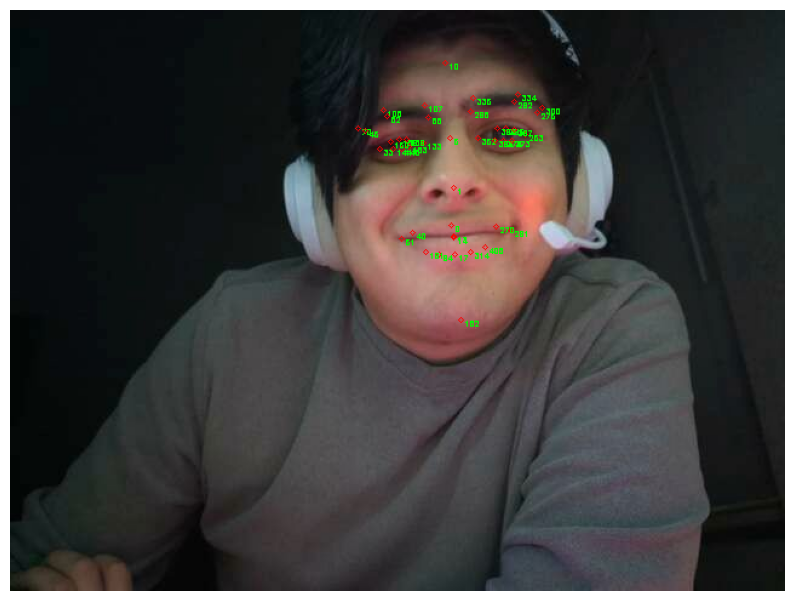

In [ ]:
frame = get_webcam()
img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
results = face_mesh.process(img_rgb)

face_landmarks = results.multi_face_landmarks[0]
important_landmarks = []
for idx in IMPORTANT_KEYPOINTS_IDX_LIST:
    lm = face_landmarks.landmark[idx]
    important_landmarks.append([lm.x, lm.y])

annotated_img = draw_keypoints(frame, face_landmarks, IMPORTANT_KEYPOINTS)
clear_output(wait=True)
plt.figure(figsize=(10,10))
plt.imshow(annotated_img)
plt.axis('off')
plt.show()

# Haciendo un modelo

### Funciones

In [ ]:
def extract_keypoints(img, face_mesh, IMPORTANT_KEYPOINTS_IDX_LIST, normalization=False, head_orientation=False):
    results = face_mesh.process(img)
    keypoints_array = None

    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        important_landmarks = []
        for idx in IMPORTANT_KEYPOINTS_IDX_LIST: #
            lm = face_landmarks.landmark[idx]
            important_landmarks.append([lm.x, lm.y])

        keypoints_array = np.array(important_landmarks)
        le_lm = face_landmarks.landmark[IMPORTANT_KEYPOINTS['left_eye_inner']]
        re_lm = face_landmarks.landmark[IMPORTANT_KEYPOINTS['right_eye_inner']]

        left_eye  = np.array([le_lm.x, le_lm.y])
        right_eye = np.array([re_lm.x, re_lm.y])

        anchor = (left_eye + right_eye) / 2
        keypoints_array = keypoints_array - anchor

        if normalization:
            eye_vec  = right_eye - left_eye
            eye_dist = np.linalg.norm(eye_vec)
            keypoints_array = keypoints_array / eye_dist

        if head_orientation:
            eye_vec = right_eye - left_eye
            angle = np.arctan2(eye_vec[1], eye_vec[0])

            R = np.array([
                [ np.cos(-angle), -np.sin(-angle) ],
                [ np.sin(-angle),  np.cos(-angle) ]
            ])

            keypoints_array = keypoints_array @ R.T
            return keypoints_array.flatten()
    else:
        return None

In [ ]:
def extract_keypoints_dataset(base_path, IMPORTANT_KEYPOINTS_IDX_LIST, normalization=False, head_orientation=False):
    keypoints_data = []
    paths = []
    users = []
    labels = []

    face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)

    folders = os.listdir(base_path)
    for folder in folders:
        print(folder)
        for user in os.listdir(base_path+folder):
            filenames = os.listdir(base_path+folder+'/'+user)
            for img_filename in filenames:
                img = cv2.imread(base_path+folder+'/'+user+'/'+img_filename)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                keypoints_array = extract_keypoints(img_rgb, face_mesh, IMPORTANT_KEYPOINTS_IDX_LIST, normalization, head_orientation)
                keypoints_data.append(keypoints_array)
                labels.append(folder)
                paths.append(base_path+folder+'/'+user+'/'+img_filename)
                users.append(user)

    df = pd.concat((pd.DataFrame(keypoints_data), pd.DataFrame(paths, columns=['path']), pd.DataFrame(users, columns=['user']), pd.DataFrame(labels, columns=['class'])), axis=1)
    return df


## Extraer los keypoints de nuestro conjunto de datos

In [ ]:
df = extract_keypoints_dataset('/content/drive/MyDrive/IA desde cero/emotion_dataset/', IMPORTANT_KEYPOINTS_IDX_LIST, normalization=True, head_orientation=True)
df.to_csv('keypoints.csv', index=False)

happy
sad
neutral
angry


## Leer conjunto de datos

In [ ]:
df = pd.read_csv('keypoints.csv')
print(df.shape)
df.head()

(1793, 91)


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,path,user,class
0,-0.087230,0.974447,-0.012321,0.036968,0.099859,-1.284334,-0.239736,3.168310,-1.014864,1.731125,...,-0.637781,0.376994,-0.426098,1.116232,-0.501186,1.529066,-0.257883,/content/drive/MyDrive/IA desde cero/emotion_d...,luis,happy
1,-0.045925,0.950659,0.015398,0.048103,0.130584,-1.226686,-0.210713,3.180754,-1.034486,1.688094,...,-0.498442,0.397206,-0.314170,1.131030,-0.351414,1.504039,-0.143811,/content/drive/MyDrive/IA desde cero/emotion_d...,luis,happy
2,-0.279427,0.986622,-0.098773,0.055379,0.136762,-1.245001,-0.385481,3.756010,-1.026699,2.223875,...,-0.540021,0.341641,-0.331073,1.146085,-0.355991,1.597209,-0.112479,/content/drive/MyDrive/IA desde cero/emotion_d...,luis,happy
3,-0.053070,0.989041,0.029361,0.021224,0.166860,-1.359059,-0.292535,3.527019,-1.206893,1.910040,...,-0.582069,0.411411,-0.377698,1.170619,-0.421935,1.571110,-0.176840,/content/drive/MyDrive/IA desde cero/emotion_d...,luis,happy
4,0.053677,1.049118,0.040481,0.063048,0.055502,-1.319446,-0.086445,3.208732,-1.005220,1.766626,...,-0.576825,0.389908,-0.374269,1.099600,-0.439402,1.459988,-0.214519,/content/drive/MyDrive/IA desde cero/emotion_d...,luis,happy


## Histograma de usuarios

<Axes: >

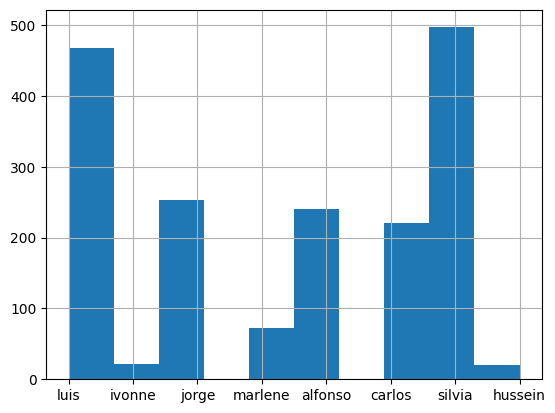

In [ ]:
df['user'].hist()

## Distribución de clases

<Axes: >

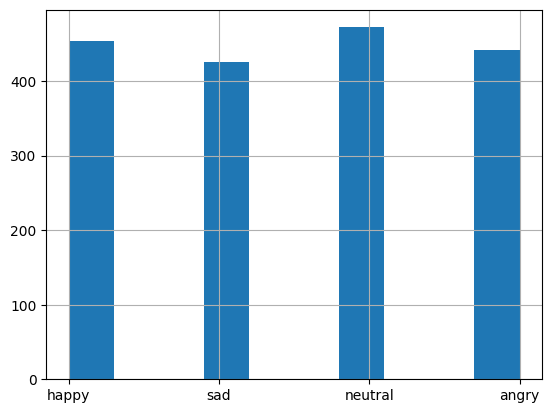

In [ ]:
df['class'].hist()

## Funciones para extraer características

In [ ]:
def distance(a, b):
    """Distancia euclidiana 2D simple."""
    return float(np.linalg.norm(a - b))


def build_feature_vector(keypoints):
    pts = keypoints.reshape(-1, 2)  # (n_points, 2)

    # Mapeo nombre -> punto (x,y)
    P = {name: pts[i] for i, name in enumerate(KEY_NAMES)}

    feats = []

    # ---------- BOCA ----------
    mouth_width = distance(P["mouth_left"], P["mouth_right"])
    mouth_open_outer = abs(P["mouth_upper_outer"][1] - P["mouth_lower_outer"][1])
    mouth_open_inner = abs(P["mouth_upper_inner"][1] - P["mouth_lower_inner"][1])

    # “curvatura” de la sonrisa (boca hacia arriba/abajo)
    mean_corner_y = 0.5 * (P["mouth_left"][1] + P["mouth_right"][1])
    smile_curvature = mean_corner_y - P["mouth_lower_outer"][1]

    feats += [
        mouth_width,
        mouth_open_outer,
        mouth_open_inner,
        smile_curvature,
    ]

    # ---------- OJOS ----------
    # ojo izquierdo
    left_eye_open = distance(P["left_eye_upper"], P["left_eye_lower"])
    left_eye_open_inner = distance(P["left_eye_upper_inner"], P["left_eye_lower_inner"])
    left_eye_open_outer = distance(P["left_eye_upper_outer"], P["left_eye_lower_outer"])

    # ojo derecho
    right_eye_open = distance(P["right_eye_upper"], P["right_eye_lower"])
    right_eye_open_inner = distance(P["right_eye_upper_inner"], P["right_eye_lower_inner"])
    right_eye_open_outer = distance(P["right_eye_upper_outer"], P["right_eye_lower_outer"])

    feats += [
        left_eye_open,
        left_eye_open_inner,
        left_eye_open_outer,
        right_eye_open,
        right_eye_open_inner,
        right_eye_open_outer,
    ]

    # ---------- CEJAS (altura respecto al ojo y pendiente) ----------
    left_eye_center = 0.5 * (P["left_eye_inner"] + P["left_eye_outer"])
    right_eye_center = 0.5 * (P["right_eye_inner"] + P["right_eye_outer"])

    left_brow_height = left_eye_center[1] - P["left_eyebrow_middle"][1]
    right_brow_height = right_eye_center[1] - P["right_eyebrow_middle"][1]

    # pendiente (inclinación) de ceja: outer vs inner
    left_brow_slope = P["left_eyebrow_outer"][1] - P["left_eyebrow_inner"][1]
    right_brow_slope = P["right_eyebrow_outer"][1] - P["right_eyebrow_inner"][1]

    feats += [
        left_brow_height,
        right_brow_height,
        left_brow_slope,
        right_brow_slope,
    ]

    # ---------- PROPORCIONES CARA ----------
    # altura de cara: frente -> mentón
    face_height = distance(P["forehead_center"], P["chin"])
    # longitud nariz: nose_bridge -> nose_tip
    nose_length = distance(P["nose_bridge"], P["nose_tip"])

    # algunos ratios que son invariantes de escala
    mouth_width_ratio = mouth_width / face_height
    nose_face_ratio = nose_length / face_height

    feats += [
        face_height,
        nose_length,
        mouth_width_ratio,
        nose_face_ratio,
    ]

    return np.array(feats)

## Librearias para entrenar y evaluar modelos

In [ ]:
from sklearn.model_selection import KFold,StratifiedKFold,GroupKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

import pickle
import seaborn as sns

## Preparar datos de entrada y salida

In [ ]:
x = df.drop(['path', 'user','class'], axis=1).to_numpy()
x_features = np.vstack([build_feature_vector(row) for row in x])

le = LabelEncoder()
y = le.fit_transform(df['class'])

## Entrenamiento con validación cruzada

Test user: ['silvia']
Fold 0: 0.6268161085301532
Test user: ['luis']
Fold 1: 0.37559205298606224
Test user: ['jorge']
Fold 2: 0.4818302375847133
Test user: ['alfonso']
Fold 3: 0.45504805467371917
Test user: ['carlos']
Fold 4: 0.38095238095238093
Test user: ['marlene']
Fold 5: 0.40368490499648135
Test user: ['ivonne']
Fold 6: 0.42051282051282046
Test user: ['hussein']
Fold 7: 0.5018315018315018
Mean F1 score macro: 0.5483206902240656
              precision    recall  f1-score   support

           0       0.43      0.44      0.43       442
           1       0.75      0.83      0.79       453
           2       0.55      0.60      0.57       472
           3       0.47      0.35      0.40       426

    accuracy                           0.56      1793
   macro avg       0.55      0.55      0.55      1793
weighted avg       0.55      0.56      0.55      1793



Text(50.722222222222214, 0.5, 'True')

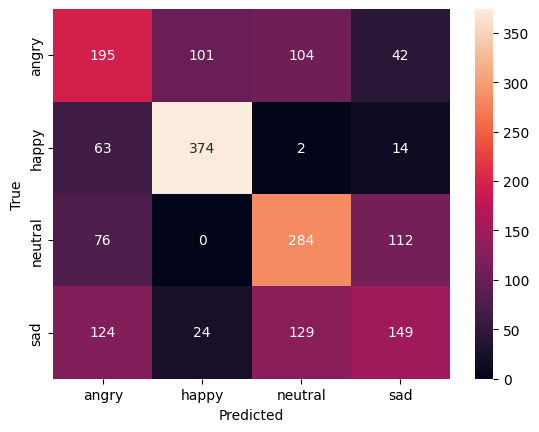

In [ ]:
kf = GroupKFold(n_splits=len(df['user'].unique()))
scores = []
conf_matrix = []
preds = []
true = []

for i, (train_index, test_index) in enumerate(kf.split(x_features,y,df['user'])):
    x_train = x_features[train_index]
    x_test = x_features[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    print(f"Test user: {df['user'].iloc[test_index].unique()}")
    model = LogisticRegression(random_state=0, max_iter=1000).fit(x_train, y_train)
    y_pred = model.predict(x_test)

    preds += list(y_pred)
    true += list(y_test)

    scores.append(f1_score(y_test, y_pred, average='macro'))
    matrix = confusion_matrix(y_test, y_pred)
    conf_matrix.append(matrix)
    #print(classification_report(y_test, y_pred))
    print(f"Fold {i}: {scores[-1]}")
print(f"Mean F1 score macro: {f1_score(true, preds, average='macro')}")
print(classification_report(true, preds))
sns.heatmap(np.sum(conf_matrix, axis=0), annot=True, fmt='g', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')

## Entrenar el modelo con todo el conjunto de datos y guardarlo junto con el label encoder

In [ ]:
model = LogisticRegression(random_state=0, max_iter=1000).fit(x_features, y)

pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(le, open('le.pkl', 'wb'))

# Probar el modelo

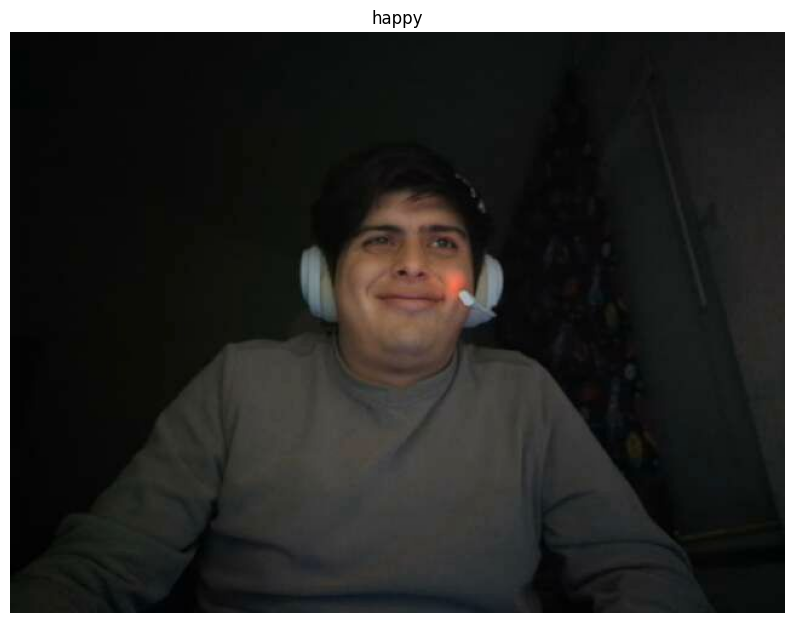

In [ ]:
frame = get_webcam()
keypoints_array = extract_keypoints(frame, face_mesh, IMPORTANT_KEYPOINTS_IDX_LIST, normalization=True, head_orientation=True)
prediction = le.inverse_transform(model.predict(build_feature_vector(keypoints_array).reshape(1,-1)))

clear_output(wait=True)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title(prediction[0])
plt.axis('off')
plt.show()